### Problem 1

Lag Model Analysis
                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.917e+07
Date:                Tue, 21 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:36:04   Log-Likelihood:                -12877.
No. Observations:                1138   AIC:                         2.577e+04
Df Residuals:                    1132   BIC:                         2.580e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        880.8861    725.279 

C:\Users\soo18\AppData\Local\Temp\ipykernel_6376\4031411247.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  country_ts.index = pd.to_datetime(country_ts.index)


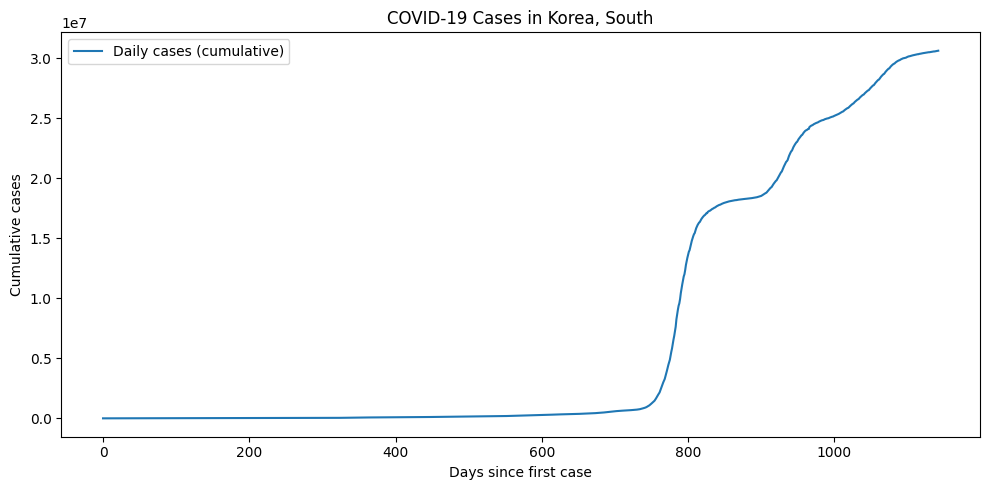


=== INTERPRETATION ===
β1 = 1.6046: a 1-case increase 1 day(s) ago is associated with 1.6046 more cases today (holding others constant).
β2 = -0.5625: a 1-case increase 2 day(s) ago is associated with -0.5625 more cases today (holding others constant).
β3 = 0.1915: a 1-case increase 3 day(s) ago is associated with 0.1915 more cases today (holding others constant).
β4 = -0.1411: a 1-case increase 4 day(s) ago is associated with -0.1411 more cases today (holding others constant).
β5 = -0.0925: a 1-case increase 5 day(s) ago is associated with -0.0925 more cases today (holding others constant).

Cumulative 5-day lag effect: 1.0000


In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = r"C:\Users\soo18\OneDrive\Desktop\Data Science\homework-8-asherkim169\time_series_covid19_confirmed_global.csv"
df = pd.read_csv(path)

country = "Korea, South"


country_df = df[df['Country/Region'] == country].drop(columns=['Province/State', 'Lat', 'Long'])
country_df = country_df.groupby('Country/Region').sum()

country_ts = country_df.T
country_ts.index = pd.to_datetime(country_ts.index)
country_ts.columns = ['cases']

first_nonzero_idx = (country_ts['cases'] > 0).idxmax()
country_ts = country_ts.loc[first_nonzero_idx:].copy()
country_ts['t'] = range(len(country_ts))

k = 5
for lag in range(1, k + 1):
    country_ts[f'Y_lag{lag}'] = country_ts['cases'].shift(lag)

df_model = country_ts.dropna().reset_index(drop=True)

X = df_model[[f'Y_lag{lag}' for lag in range(1, k + 1)]]
X = sm.add_constant(X)
y = df_model['cases']

model = sm.OLS(y, X).fit()

print("Lag Model Analysis")
print(model.summary())

plt.figure(figsize=(10, 5))
plt.plot(country_ts['t'], country_ts['cases'], label='Daily cases (cumulative)')
plt.title(f"COVID-19 Cases in {country}")
plt.xlabel("Days since first case")
plt.ylabel("Cumulative cases")
plt.legend()
plt.tight_layout()
plt.show()

coefs = model.params
print("\n=== INTERPRETATION ===")
for i in range(1, k + 1):
    beta = coefs[f'Y_lag{i}']
    print(f"β{i} = {beta:.4f}: a 1-case increase {i} day(s) ago "
          f"is associated with {beta:.4f} more cases today (holding others constant).")

total_effect = sum(coefs[f'Y_lag{i}'] for i in range(1, k + 1))
print(f"\nCumulative 5-day lag effect: {total_effect:.4f}")

### Problem 2

(a) MSE (South Korea, all data) = 394552870.4008
(b) MSE (South Korea, fit first half and then MSE second half) = 860172140.4005


C:\Users\soo18\AppData\Local\Temp\ipykernel_6376\89969348.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts.index = pd.to_datetime(ts.index)


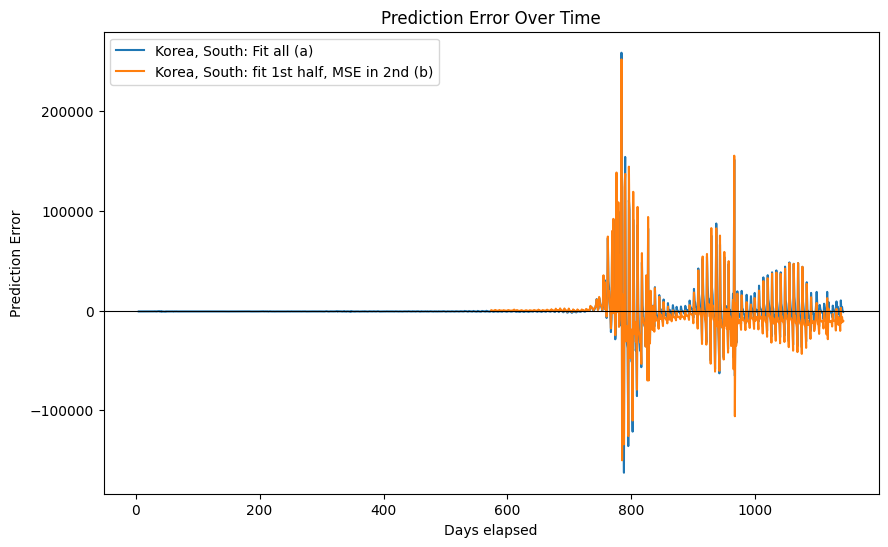

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

path = r"C:\Users\soo18\OneDrive\Desktop\Data Science\homework-8-asherkim169\time_series_covid19_confirmed_global.csv"
df = pd.read_csv(path)

def prepare_country_data(df, country, k=5):
    country_df = df[df['Country/Region'] == country].drop(columns=['Province/State', 'Lat', 'Long'], errors='ignore')
    country_df = country_df.groupby('Country/Region').sum()
    ts = country_df.T
    ts.index = pd.to_datetime(ts.index)
    ts.columns = ['cases']
    first_nonzero_idx = (ts['cases'] > 0).idxmax()
    ts = ts.loc[first_nonzero_idx:].copy()
    ts['t'] = np.arange(len(ts))
    for lag in range(1, k+1):
        ts[f'Y_lag{lag}'] = ts['cases'].shift(lag)
    ts = ts.dropna().reset_index(drop=True)
    return ts

def fit_distributed_lag(ts, k=5):
    X = ts[[f'Y_lag{i}' for i in range(1, k+1)]]
    X = sm.add_constant(X)
    y = ts['cases']
    model = sm.OLS(y, X).fit()
    ts['y_pred'] = model.predict(X)
    ts['error'] = y - ts['y_pred']
    return model, ts

country_A = "Korea, South"

k = 5
A_data = prepare_country_data(df, country_A, k)

model_A_all, A_all_pred = fit_distributed_lag(A_data, k)
mse_A_all = mean_squared_error(A_all_pred['cases'], A_all_pred['y_pred'])
print(f"(a) MSE (South Korea, all data) = {mse_A_all:.4f}")

split = len(A_data) // 2
train_A = A_data.iloc[:split].copy()
test_A = A_data.iloc[split:].copy()

X_train = sm.add_constant(train_A[[f'Y_lag{i}' for i in range(1, k+1)]])
y_train = train_A['cases']
model_half = sm.OLS(y_train, X_train).fit()

X_test = sm.add_constant(test_A[[f'Y_lag{i}' for i in range(1, k+1)]])
test_A['y_pred'] = model_half.predict(X_test)
test_A['error'] = test_A['cases'] - test_A['y_pred']
mse_A_half = mean_squared_error(test_A['cases'], test_A['y_pred'])
print(f"(b) MSE (South Korea, fit first half and then MSE second half) = {mse_A_half:.4f}")

plt.figure(figsize=(10,6))
plt.plot(A_all_pred['t'], A_all_pred['error'], label=f"{country_A}: Fit all (a)")
plt.plot(test_A['t'], test_A['error'], label=f"{country_A}: fit 1st half, MSE in 2nd (b)")
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Prediction Error Over Time")
plt.xlabel("Days elapsed")
plt.ylabel("Prediction Error")
plt.legend()


### Problem 3

MSE for applying South Korea model to China: 21184184.4143


C:\Users\soo18\AppData\Local\Temp\ipykernel_6376\3746527387.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts.index = pd.to_datetime(ts.index)
C:\Users\soo18\AppData\Local\Temp\ipykernel_6376\3746527387.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts.index = pd.to_datetime(ts.index)


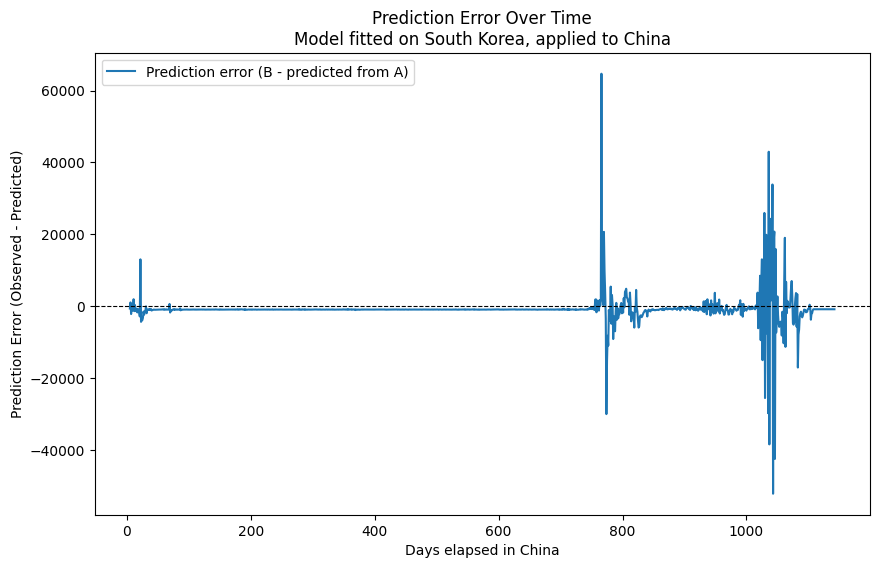

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

path = r"C:\Users\soo18\OneDrive\Desktop\Data Science\homework-8-asherkim169\time_series_covid19_confirmed_global.csv"
df = pd.read_csv(path)

def prepare_country_data(df, country, k=5):
    country_df = df[df['Country/Region'] == country].drop(columns=['Province/State', 'Lat', 'Long'], errors='ignore')
    country_df = country_df.groupby('Country/Region').sum()
    ts = country_df.T
    ts.index = pd.to_datetime(ts.index)
    ts.columns = ['cases']
    
    first_nonzero_idx = (ts['cases'] > 0).idxmax()
    ts = ts.loc[first_nonzero_idx:].copy()
    ts['t'] = np.arange(len(ts))
    
    for lag in range(1, k + 1):
        ts[f'Y_lag{lag}'] = ts['cases'].shift(lag)
    
    ts = ts.dropna().reset_index(drop=True)
    return ts

country_A = "Korea, South"
country_B = "China"
k = 5

A_data = prepare_country_data(df, country_A, k)
B_data = prepare_country_data(df, country_B, k)

X_A = sm.add_constant(A_data[[f'Y_lag{i}' for i in range(1, k + 1)]])
y_A = A_data['cases']
model_A = sm.OLS(y_A, X_A).fit()

X_B = sm.add_constant(B_data[[f'Y_lag{i}' for i in range(1, k + 1)]], has_constant='add')
y_B = B_data['cases']

B_data['y_pred_from_A'] = model_A.predict(X_B)
B_data['error'] = y_B - B_data['y_pred_from_A']

mse_B = mean_squared_error(y_B, B_data['y_pred_from_A'])
print(f"MSE for applying South Korea model to China: {mse_B:.4f}")

plt.figure(figsize=(10,6))
plt.plot(B_data['t'], B_data['error'], label='Prediction error (B - predicted from A)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Prediction Error Over Time\nModel fitted on South Korea, applied to China")
plt.xlabel("Days elapsed in China")
plt.ylabel("Prediction Error (Observed - Predicted)")
plt.legend()
plt.show()


### Problem 4

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

path = r"C:\Users\soo18\OneDrive\Desktop\Data Science\homework-8-asherkim169\time_series_covid19_confirmed_global.csv"
df = pd.read_csv(path)

country = "Korea, South"
k = 5 

country_df = df[df['Country/Region'] == country].drop(columns=['Province/State','Lat','Long','Country/Region'], errors='ignore')
cases = country_df.sum(axis=0)
cases = cases[cases > 0]
cases = pd.Series(cases.values, index=pd.to_datetime(cases.index))

D = cases.diff().fillna(0)
Z = (D > 0).astype(int)

data = pd.DataFrame({'Z': Z})
for lag in range(1, k+1):
    data[f'Z_lag{lag}'] = data['Z'].shift(lag)

data = data.dropna()

X = sm.add_constant(data[[f'Z_lag{i}' for i in range(1, k+1)]])
y = data['Z']
model = sm.Logit(y, X).fit(disp=False)

print("Logistic regression summary")
print(model.summary())

print("\nInterpretation of coefficients (odds ratios):")
for lag in range(1, k+1):
    coef = model.params[f'Z_lag{lag}']
    orr = np.exp(coef)
    print(f"Z_lag{lag}: coef={coef:.3f}, odds ratio={orr:.2f}")
    print("Odds ratio >1: cases continue to increase. \nOdds ratio <1: no longer increases.")


Logistic regression summary
                           Logit Regression Results                           
Dep. Variable:                      Z   No. Observations:                 1138
Model:                          Logit   Df Residuals:                     1132
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Oct 2025   Pseudo R-squ.:                  0.2905
Time:                        19:18:14   Log-Likelihood:                -59.679
converged:                       True   LL-Null:                       -84.118
Covariance Type:            nonrobust   LLR p-value:                 2.350e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7987      1.071     -2.614      0.009      -4.898      -0.700
Z_lag1         2.9511      0.766      3.851      0.000       1.449       4.453
Z_lag2         0.6836   

C:\Users\soo18\AppData\Local\Temp\ipykernel_6376\3167305817.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cases = pd.Series(cases.values, index=pd.to_datetime(cases.index))
